In [53]:
import sys
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from datetime import datetime
import h5py
import scipy.stats as stats

# Set matplotlib style
%matplotlib widget
%load_ext autoreload
%autoreload 2
plt.style.use('../anemotaxis.mplstyle')
import core.data_loader as data_loader
import core.data_processor as data_processor
import viz.plot_data as plot_data
import utils.preprocessing as preprocessing

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
# Just provide your experiment dates here:
experiment_dates_control = [
    # timothee
    '20240219_143334',
    '20240223_112627', 
    '20240226_145653',
    '20240226_145653',
    '20240226_163646',
    '20240301_105819',
    '20240301_121446',
    '20240304_151714',
    '20240304_162010',
    '20240308_104430',
    '20240308_124423',
    # mine
    '20250711_112928',
    '20250712_115018',
    '20250712_131147',
    '20250715_112915',
    '20250715_112915',
    '20250801_111753',
    '20250804_110703',
    '20250805_103511',
    '20250908_135226',
    '20250908_140738'
]
experiment_dates_ss01948 = [
    '20240219_140808', 
    '20240223_110610',
    '20240226_160620',
    '20240301_114359',
    '20240304_153212',
    '20240308_115957',
    '20250620_114411',
    '20250801_113341',
    '20250804_120639',
    '20250805_110603'
]

experiment_dates_ss00864 = [
    '20240219_151622',
    '20240223_122519', 
    '20240226_162227',
    '20240301_115953',
    '20240304_144626',
    '20240308_123028',
    '20250606_151520',
    '20250610_151515',
    '20250613_115904',
    '20250616_112805',
    '20250801_121925',
    '20250802_125236',
    '20250804_113758',
    '20250805_113429'
]

experiment_dates_mb143b = [
    '20240226_152833',
    '20240301_112859',
    '20240304_143024',
    '20240308_131239',
    '20240614_150918',
    '20250711_115827',
    '20250712_124448',
    '20250715_115737'
]

experiment_dates_ss01696 = [
    '20240219_155844',
    '20240223_115010',
    '20240226_170838',
    '20240301_111323',
    '20240304_141357',
    '20240308_125815',
    '20250711_122648',
    '20250712_121626',
    '20250715_110237'
]

experiment_dates_ss01757 = [
    '20240219_145347',
    '20240223_120812',
    '20240226_165304',
    '20240301_104205',
    '20240304_150157',
    '20240308_121454',
    '20250627_112155'
]

experiment_dates_abby = [
    '20250620_150116',
    '20250624_151833',
    '20250626_144339',
    '20250908_142208',
    '20250908_143537'
]

experiment_dates_control_abby = [
    '20250620_144253',
    '20250624_143316',
    '20250626_142647',
    '20250908_135226',
    '20250908_140738'
]

In [56]:
# Define genotype configurations
genotype_configs = {
    'control': {
        'name': 'FCF_attP2-40@UAS_TNT_2_0003',
        'base_path': '/Users/sharbat/Projects/anemotaxis/data/FCF_attP2-40@UAS_TNT_2_0003/p_5gradient2_2s1x600s0s#n#n#n',
        'experiment_dates': experiment_dates_control,
        'linestyle': '--',
        'alpha': 0.2,
        'label': 'Control'
    },
    # 'ss01948': {
    #     'name': 'GMR_SS01948@UAS_TNT_2_0003',
    #     'base_path': '/Users/sharbat/Projects/anemotaxis/data/GMR_SS01948@UAS_TNT_2_0003/p_5gradient2_2s1x600s0s#n#n#n',
    #     'experiment_dates': experiment_dates_ss01948,
    #     'linestyle': '-',
    #     'alpha': 0.4,
    #     'label': 'SS01948'
    # }
    # 'mb143b': {
    #     'name': 'GMR_MB143B@UAS_TNT_2_0003',
    #     'base_path': '/Users/sharbat/Projects/anemotaxis/data/GMR_MB143B@UAS_TNT_2_0003/p_5gradient2_2s1x600s0s#n#n#n',
    #     'experiment_dates': experiment_dates_mb143b,
    #     'linestyle': '-',
    #     'alpha': 0.4,
    #     'label': 'MB143b'
    # }
    # 'ss00864': {
    # 'name': 'GMR_SS00864@UAS_TNT_2_0003',
    # 'base_path': '/Users/sharbat/Projects/anemotaxis/data/GMR_SS00864@UAS_TNT_2_0003/p_5gradient2_2s1x600s0s#n#n#n',
    # 'experiment_dates': experiment_dates_ss00864,
    # 'linestyle': '-',
    # 'alpha': 0.4,
    # 'label': 'SS00864'
#     'ss01696': {
#     'name': 'GMR_SS01696@UAS_TNT_2_0003',
#     'base_path': '/Users/sharbat/Projects/anemotaxis/data/GMR_SS01696@UAS_TNT_2_0003/p_5gradient2_2s1x600s0s#n#n#n',
#     'experiment_dates': experiment_dates_ss01696,
#     'linestyle': '-',
#     'alpha': 0.4,
#     'label': 'SS01696'
# }
    'ss01757': {
        'name': 'GMR_SS01757@UAS_TNT_2_0003',
        'base_path': '/Users/sharbat/Projects/anemotaxis/data/GMR_SS01757@UAS_TNT_2_0003/p_5gradient2_2s1x600s0s#n#n#n',
        'experiment_dates': experiment_dates_ss01757,
        'linestyle': '-',
        'alpha': 0.4,
        'label': 'SS01757'
    }
}



# Load data for all genotypes
genotype_data = {}
for genotype_key, config in genotype_configs.items():
    genotype_data[genotype_key] = data_loader.load_genotype_data(genotype_key, config)

# Print summary
print("✅ All genotypes loaded successfully!")
for genotype_key, data in genotype_data.items():
    n_larvae = data['metadata']['n_larvae']
    label = data['metadata']['label']
    print(f"📊 {label}: {n_larvae} larvae")

# Set output directory
output_dir = '/Users/sharbat/Projects/anemotaxis/data/genotype_comparison'
os.makedirs(output_dir, exist_ok=True)

🔄 Loading Control dataset...
✅ 20240219_143334: Using latest file with timestamp 20251015_134223
✅ 20240223_112627: Using latest file with timestamp 20251015_134111
✅ 20240226_145653: Using latest file with timestamp 20251015_134036
✅ 20240226_145653: Using latest file with timestamp 20251015_134036
✅ 20240226_163646: Using latest file with timestamp 20251015_133941
✅ 20240301_105819: Using latest file with timestamp 20251015_133855
✅ 20240301_121446: Using latest file with timestamp 20251015_133821
✅ 20240304_151714: Using latest file with timestamp 20251015_133738
✅ 20240304_162010: Using latest file with timestamp 20251015_133625
✅ 20240308_104430: Using latest file with timestamp 20251015_133542
✅ 20240308_124423: Using latest file with timestamp 20251015_133504
✅ 20250711_112928: Using latest file with timestamp 20251015_133410
✅ 20250712_115018: Using latest file with timestamp 20251015_133242
✅ 20250712_131147: Using latest file with timestamp 20251015_133214
✅ 20250715_112915: 

In [36]:
# # Automatically get the latest .h5 files
# base_path_control = '/Users/sharbat/Projects/anemotaxis/data/FCF_attP2-40@UAS_TNT_2_0003/p_5gradient2_2s1x600s0s#n#n#n'
# result_files = get_latest_analysis_files(experiment_dates_control, base_path=base_path_control)

# # For use with combined analysis
# base_path_ss01948 = '/Users/sharbat/Projects/anemotaxis/data/GMR_SS01948@UAS_TNT_2_0003/p_5gradient2_2s1x600s0s#n#n#n'
# result_files_experiment = get_latest_analysis_files(experiment_dates_ss01948, base_path=base_path_ss01948)

# # Verify the files exist
# print(f"\n🔍 Verifying files exist:")
# for file in result_files:
#     exists = "✅" if os.path.exists(file) else "❌"
#     print(f"  {exists} {os.path.basename(file)}")

# print(result_files)


# base_path_control = '/Users/sharbat/Projects/anemotaxis/data/T2_Ladder_Neuron_Data/FCF_attP2-40@UAS_TNT_2_0003_p_5gradient2/p_5gradient2_2s1x600s0s#n#n#n'
# result_files = get_latest_analysis_files(experiment_dates_control_abby, base_path=base_path_control)

# base_path_experiment = '/Users/sharbat/Projects/anemotaxis/data/T2_Ladder_Neuron_Data/GMR_SS01632@UAS_TNT_2_0003_p_5gradient2/p_5gradient2_2s1x600s0s#n#n#n'
# result_files = get_latest_analysis_files(experiment_dates_abby, base_path=base_path_experiment)


In [37]:
# # Load both datasets
# print("🔄 Loading control dataset...")
# base_path_control = '/Users/sharbat/Projects/anemotaxis/data/FCF_attP2-40@UAS_TNT_2_0003/p_5gradient2_2s1x600s0s#n#n#n'
# result_files_control = get_latest_analysis_files(experiment_dates_control, base_path=base_path_control)

# print("🔄 Loading SS01948 dataset...")
# base_path_ss01948 = '/Users/sharbat/Projects/anemotaxis/data/GMR_SS01948@UAS_TNT_2_0003/p_5gradient2_2s1x600s0s#n#n#n'
# result_files_ss01948 = get_latest_analysis_files(experiment_dates_ss01948, base_path=base_path_ss01948)

# # Combine analysis results for both datasets
# print("🔄 Combining control analysis results...")
# # Control dataset results
# combined_run_prob_control = combine_analysis_results(result_files_control, 'run_prob_results')
# combined_run_prob_time_control = combine_analysis_results(result_files_control, 'run_prob_time_results')
# combined_turn_prob_control = combine_analysis_results(result_files_control, 'turn_prob_results')
# combined_turn_prob_time_control = combine_analysis_results(result_files_control, 'turn_prob_time_results')
# combined_velocity_control = combine_analysis_results(result_files_control, 'velocity_results')
# combined_velocity_time_control = combine_analysis_results(result_files_control, 'velocity_time_results')
# combined_backup_prob_control = combine_analysis_results(result_files_control, 'backup_prob_results')
# combined_backup_prob_time_control = combine_analysis_results(result_files_control, 'backup_prob_time_results')

# # Head cast analyses - control
# combined_bias_first_control = combine_analysis_results(result_files_control, 'bias_results_first')
# combined_bias_turn_control = combine_analysis_results(result_files_control, 'bias_results_turn')

# print("🔄 Combining SS01948 analysis results...")
# # SS01948 dataset results
# combined_run_prob_ss01948 = combine_analysis_results(result_files_ss01948, 'run_prob_results')
# combined_run_prob_time_ss01948 = combine_analysis_results(result_files_ss01948, 'run_prob_time_results')
# combined_turn_prob_ss01948 = combine_analysis_results(result_files_ss01948, 'turn_prob_results')
# combined_turn_prob_time_ss01948 = combine_analysis_results(result_files_ss01948, 'turn_prob_time_results')
# combined_velocity_ss01948 = combine_analysis_results(result_files_ss01948, 'velocity_results')
# combined_velocity_time_ss01948 = combine_analysis_results(result_files_ss01948, 'velocity_time_results')
# combined_backup_prob_ss01948 = combine_analysis_results(result_files_ss01948, 'backup_prob_results')
# combined_backup_prob_time_ss01948 = combine_analysis_results(result_files_ss01948, 'backup_prob_time_results')

# # Head cast analyses - SS01948
# combined_bias_first_ss01948 = combine_analysis_results(result_files_ss01948, 'bias_results_first')
# combined_bias_turn_ss01948 = combine_analysis_results(result_files_ss01948, 'bias_results_turn')

# # Set output directory (you can choose either path or create a combined one)
# output_dir = '/Users/sharbat/Projects/anemotaxis/data/combined_analysis'
# os.makedirs(output_dir, exist_ok=True)

# print("✅ Both datasets loaded successfully!")
# print(f"📊 Control larvae: {combined_run_prob_control['n_larvae'] if combined_run_prob_control else 0}")
# print(f"📊 SS01948 larvae: {combined_run_prob_ss01948['n_larvae'] if combined_run_prob_ss01948 else 0}")

In [38]:
# output_dir = os.path.join(base_path_ss01948, 'analyses')
# # output_dir = os.path.join(base_path_control, 'analyses')
# # output_dir = os.path.join(base_path_experiment, 'analyses')

# os.makedirs(output_dir, exist_ok=True)

# # Combine all analysis results (matching analyze_single_anemotaxis.ipynb)
# print("🔄 Combining analysis results...")

# # Basic behavioral analyses
# combined_run_prob = combine_analysis_results(result_files, 'run_prob_results')
# combined_run_prob_time = combine_analysis_results(result_files, 'run_prob_time_results')
# combined_turn_prob = combine_analysis_results(result_files, 'turn_prob_results')
# combined_turn_prob_time = combine_analysis_results(result_files, 'turn_prob_time_results')
# combined_velocity = combine_analysis_results(result_files, 'velocity_results')
# combined_velocity_time = combine_analysis_results(result_files, 'velocity_time_results')
# combined_turn_amp = combine_analysis_results(result_files, 'turn_amp_results')
# combined_turn_amp_time = combine_analysis_results(result_files, 'turn_amp_time_results')
# combined_turn_rate = combine_analysis_results(result_files, 'turn_rate_results')
# combined_turn_rate_time = combine_analysis_results(result_files, 'turn_rate_time_results')
# combined_backup_prob = combine_analysis_results(result_files, 'backup_prob_results')
# combined_backup_prob_time = combine_analysis_results(result_files, 'backup_prob_time_results')

# # Head cast analyses
# combined_cast_events = combine_analysis_results(result_files, 'cast_events_data')
# combined_bias_first = combine_analysis_results(result_files, 'bias_results_first')
# # combined_bias_last = combine_analysis_results(result_files, 'bias_results_last')
# # combined_bias_all = combine_analysis_results(result_files, 'bias_results_all')
# combined_bias_turn = combine_analysis_results(result_files, 'bias_results_turn')
# combined_head_cast_orientation = combine_analysis_results(result_files, 'head_cast_orientation_results')
# combined_head_cast_time = combine_analysis_results(result_files, 'head_cast_time_results')

# # Navigational Index analyses
# combined_ni_time = combine_analysis_results(result_files, 'ni_time_results')
# combined_ni_single = combine_analysis_results(result_files, 'ni_single_results')

# print("✅ All analysis results combined successfully!")
# print(f"📊 Total datasets processed: {len(result_files)}")

# # Print summary of combined data with detailed status
# print("\n📋 Summary of combined analyses:")

# # Basic behavioral analyses status
# behavioral_analyses = {
#     'run_prob': combined_run_prob,
#     'run_prob_time': combined_run_prob_time,
#     'turn_prob': combined_turn_prob,
#     'turn_prob_time': combined_turn_prob_time,
#     'velocity': combined_velocity,
#     'velocity_time': combined_velocity_time,
#     'turn_amp': combined_turn_amp,
#     'turn_amp_time': combined_turn_amp_time,
#     'backup_prob': combined_backup_prob,
#     'backup_prob_time': combined_backup_prob_time
# }

# for name, result in behavioral_analyses.items():
#     status = "✅" if result else "❌"
#     n_larvae = result.get('n_larvae', 0) if result else 0
#     print(f"  {status} {name}: {n_larvae} larvae")

# # Head cast analyses status
# head_cast_analyses = {
#     'cast_events': combined_cast_events,
#     'bias_first': combined_bias_first,
#     'bias_last': combined_bias_last,
#     'bias_all': combined_bias_all,
#     'head_cast_orientation': combined_head_cast_orientation,
#     'head_cast_time': combined_head_cast_time
# }

# print("\n🎯 Head cast analyses:")
# for name, result in head_cast_analyses.items():
#     status = "✅" if result else "❌"
#     if result:
#         if 'n_larvae' in result:
#             n_larvae = result['n_larvae']
#         elif 'n_values' in result:
#             n_values = result['n_values']
#             print(f"  {status} {name}: {n_values} values")
#             continue
#         else:
#             n_larvae = 0
#         print(f"  {status} {name}: {n_larvae} larvae")
#     else:
#         print(f"  {status} {name}: 0 larvae")

# # NI analyses status
# ni_analyses = {
#     'ni_time': combined_ni_time,
#     'ni_single': combined_ni_single
# }

# print("\n🧭 Navigational Index analyses:")
# for name, result in ni_analyses.items():
#     status = "✅" if result else "❌"
#     if result:
#         n_larvae = result.get('n_larvae', 0)
#         if 'NI_x_clean' in result:
#             n_x_values = len(result['NI_x_clean'])
#             n_y_values = len(result['NI_y_clean']) if 'NI_y_clean' in result else 0
#             print(f"  {status} {name}: {n_larvae} larvae, {n_x_values} x-values, {n_y_values} y-values")
#         else:
#             print(f"  {status} {name}: {n_larvae} larvae")
#     else:
#         print(f"  {status} {name}: 0 larvae")

# # Overall summary
# if combined_run_prob and 'n_larvae' in combined_run_prob:
#     print(f"\n🐛 Total larvae in combined analysis: {combined_run_prob['n_larvae']}")

In [39]:
# Updated function to plot genotype comparisons with head cast support
def plot_genotype_comparison(genotype_data, analysis_type, plot_style='histogram', ax=None, **kwargs):
    """Plot comparison of multiple genotypes for a given analysis type."""
    
    # Define colors for different analysis types
    color_map = {
        'run': 'black',
        'turn': 'red', 
        'backup': 'cyan',
        'velocity': 'black',
        'turn_amplitude': 'red',
        'head_cast': 'purple'  # Ensure this is purple
    }
    
    # Force purple color for head cast analyses
    if 'head_cast' in analysis_type or kwargs.get('plot_type') == 'head_cast':
        base_color = 'purple'
    elif 'plot_type' in kwargs and kwargs['plot_type'] in color_map:
        base_color = color_map[kwargs['plot_type']]
    elif 'color' in kwargs:
        base_color = kwargs['color']
    else:
        # Determine from analysis_type
        if 'run' in analysis_type:
            base_color = color_map['run']
        elif 'turn_prob' in analysis_type:
            base_color = color_map['turn']
        elif 'backup' in analysis_type:
            base_color = color_map['backup']
        elif 'turn_amp' in analysis_type:
            base_color = color_map['turn_amplitude']
        elif 'velocity' in analysis_type:
            base_color = color_map['velocity']
        else:
            base_color = 'black'  # default
    
    # Determine plot_type for the plotting functions
    if 'plot_type' in kwargs:
        behavior_plot_type = kwargs['plot_type']
    elif 'run' in analysis_type:
        behavior_plot_type = 'run'
    elif 'turn_prob' in analysis_type:
        behavior_plot_type = 'turn'
    elif 'backup' in analysis_type:
        behavior_plot_type = 'backup'
    elif 'velocity' in analysis_type:
        behavior_plot_type = 'velocity'
    elif 'turn_amp' in analysis_type:
        behavior_plot_type = 'turn_amplitude'
    elif 'head_cast' in analysis_type:
        behavior_plot_type = 'head_cast'
    else:
        behavior_plot_type = 'run'  # default
    
    # Remove conflicting arguments from kwargs
    clean_kwargs = kwargs.copy()
    clean_kwargs.pop('plot_type', None)
    clean_kwargs.pop('color', None)  # Remove color override to use our mapping
    
    for i, (genotype_key, data) in enumerate(genotype_data.items()):
        if analysis_type not in data or not data[analysis_type]:
            continue
            
        style = data['metadata']['style']
        label = data['metadata']['label']
        
        # Create plot-specific kwargs
        if plot_style == 'histogram':
            plot_kwargs = {
                **style, 
                'label': label, 
                'color': base_color,
                'plot_type': behavior_plot_type,
                **clean_kwargs
            }
                
            plot_data.plot_orientation_histogram(
                data[analysis_type], 
                ax=ax, 
                **plot_kwargs
            )
            
        elif plot_style == 'time_series':
            plot_kwargs = {
                **style, 
                'label': label, 
                'color': base_color,
                'plot_type': behavior_plot_type,
                **clean_kwargs
            }
                
            plot_data.plot_metric_over_time(
                data[analysis_type], 
                ax=ax, 
                **plot_kwargs
            )
            
        elif plot_style == 'polar':
            # For polar plots, use alpha differences only (no color differences)
            alpha_values = [0.8, 0.5]  # First genotype more opaque, second more transparent
            alpha = alpha_values[i] if i < len(alpha_values) else 0.3
            
            # Extract only the parameters that plot_orientation_histogram_polar accepts
            polar_kwargs = {
                k: v for k, v in clean_kwargs.items() 
                if k in ['min_amplitude', 'ylim']
            }
            
            # Add polar-specific parameters
            polar_kwargs.update({
                'plot_type': behavior_plot_type,
                'bar_style': True,
                'tick_fontsize': 10,
                'se_alpha': alpha,
                'label': label,
                'color': base_color
            })
            
            plot_data.plot_orientation_histogram_polar(
                data[analysis_type], 
                ax=ax,
                **polar_kwargs
            )
    
    # Add legend for histogram and time_series plots
    if ax and plot_style in ['histogram', 'time_series']:
        ax.legend()
    
    # Add legend for polar plots if there are multiple genotypes
    elif ax and plot_style == 'polar' and len(genotype_data) > 1:
        from matplotlib.patches import Patch
        legend_elements = []
        alpha_values = [0.8, 0.5]
        
        for i, (genotype_key, data) in enumerate(genotype_data.items()):
            if analysis_type in data and data[analysis_type]:
                alpha = alpha_values[i] if i < len(alpha_values) else 0.3
                label = data['metadata']['label']
                legend_elements.append(Patch(facecolor=base_color, alpha=alpha, label=label))
        
        if legend_elements:
            ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.3, 1.0))

/var/folders/qs/_71td1zx7kjd4t5xhw9wndn00000gp/T/ipykernel_49946/1062060056.py:63: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax2.boxplot(box_data, labels=[d[:8] for d in dates], patch_artist=True)
/var/folders/qs/_71td1zx7kjd4t5xhw9wndn00000gp/T/ipykernel_49946/1062060056.py:86: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax3.boxplot(box_data, labels=[d[:8] for d in dates], patch_artist=True)


Comprehensive comparison figure saved to: /Users/sharbat/Projects/anemotaxis/data/genotype_comparison/comprehensive_ni_behavioral_comparison_Control_vs_SS01757.pdf


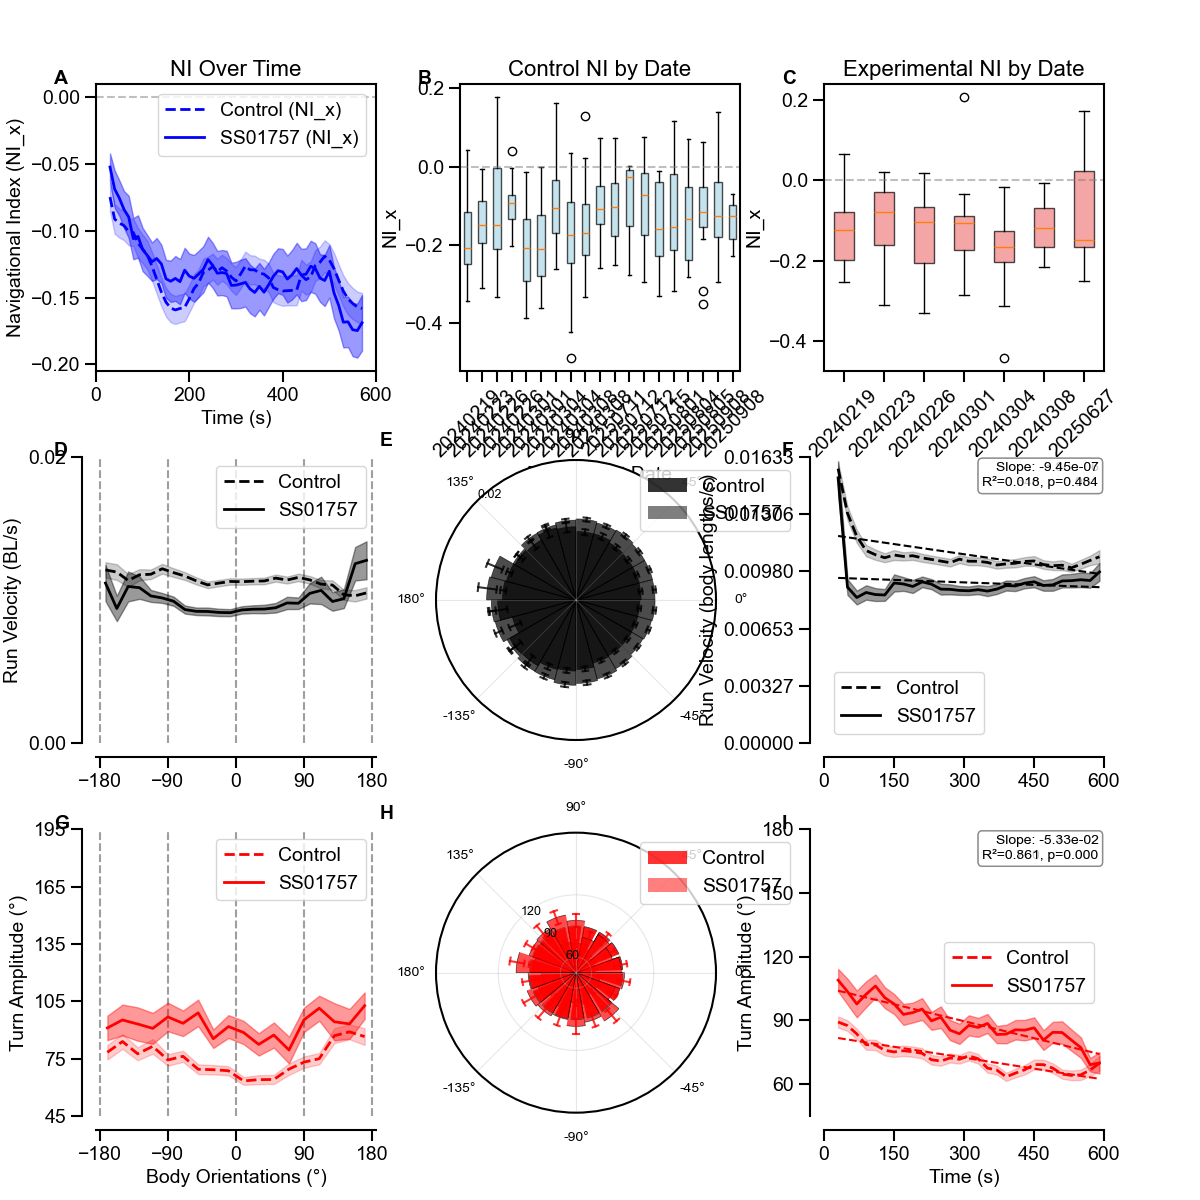

In [40]:
def create_comprehensive_comparison_figure(genotype_data, output_dir):
    """Create a comprehensive 3x3 comparison figure with NI and behavioral data."""
    
    fig = plt.figure(figsize=(12,12))
    gs = GridSpec(3, 3, figure=fig, 
                  left=0.08, right=0.92,
                  top=0.93, bottom=0.07,
                  wspace=0.3, hspace=0.3)

    # ========================
    # TOP ROW: Navigational Index
    # ========================
    
    # Panel A: NI over time (both genotypes)
    ax1 = fig.add_subplot(gs[0, 0])
    
    for genotype_key, data in genotype_data.items():
        if 'ni_time_results' not in data or not data['ni_time_results']:
            continue
            
        ni_data = data['ni_time_results']
        style = data['metadata']['style']
        label = data['metadata']['label']
        
        if 'time_centers' in ni_data and 'mean_NI_x' in ni_data:
            time_centers = ni_data['time_centers']
            mean_ni_x = ni_data['mean_NI_x']
            se_ni_x = ni_data.get('se_NI_x', np.zeros_like(mean_ni_x))
            
            # Plot mean line
            ax1.plot(time_centers, mean_ni_x, 
                    linestyle=style['linestyle'], 
                    linewidth=2, 
                    label=f'{label} (NI_x)',
                    color='blue')
            
            # Plot error bars
            ax1.fill_between(time_centers, 
                           mean_ni_x - se_ni_x, 
                           mean_ni_x + se_ni_x,
                           alpha=style['se_alpha'], 
                           color='blue')
    
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Navigational Index (NI_x)')
    ax1.set_title('NI Over Time')
    ax1.legend()
    ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    ax1.set_xlim(0, 600)
    ax1.text(-0.15, 1.05, 'A', transform=ax1.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')
    
    # Panel B: Control NI by date
    ax2 = fig.add_subplot(gs[0, 1])
    
    control_data = genotype_data.get('control', {}).get('ni_single_results', {})
    if control_data and 'NI_x_by_date' in control_data:
        ni_x_by_date = control_data['NI_x_by_date']
        dates = sorted(ni_x_by_date.keys())
        
        # Create box plot data
        box_data = [ni_x_by_date[date] for date in dates]
        
        bp = ax2.boxplot(box_data, labels=[d[:8] for d in dates], patch_artist=True)
        for patch in bp['boxes']:
            patch.set_facecolor('lightblue')
            patch.set_alpha(0.7)
    
    ax2.set_xlabel('Experiment Date')
    ax2.set_ylabel('NI_x')
    ax2.set_title('Control NI by Date')
    ax2.tick_params(axis='x', rotation=45)
    ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    ax2.text(-0.15, 1.05, 'B', transform=ax2.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')
    
    # Panel C: SS01948 NI by date
    ax3 = fig.add_subplot(gs[0, 2])
    
    ss01948_data = genotype_data.get('ss01757', {}).get('ni_single_results', {})
    if ss01948_data and 'NI_x_by_date' in ss01948_data:
        ni_x_by_date = ss01948_data['NI_x_by_date']
        dates = sorted(ni_x_by_date.keys())
        
        # Create box plot data
        box_data = [ni_x_by_date[date] for date in dates]
        
        bp = ax3.boxplot(box_data, labels=[d[:8] for d in dates], patch_artist=True)
        for patch in bp['boxes']:
            patch.set_facecolor('lightcoral')
            patch.set_alpha(0.7)
    
    ax3.set_xlabel('Experiment Date')
    ax3.set_ylabel('NI_x')
    ax3.set_title('Experimental NI by Date')
    ax3.tick_params(axis='x', rotation=45)
    ax3.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    ax3.text(-0.15, 1.05, 'C', transform=ax3.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')
    
    # ========================
    # MIDDLE ROW: Run Velocity
    # ========================
    
    # Panel D: Run velocity histogram
    ax4 = fig.add_subplot(gs[1, 0])
    plot_genotype_comparison(genotype_data, 'velocity_results', 'histogram', 
                           ax=ax4, ylabel='Run Velocity (BL/s)', show_xlabel=False,
                           color='black')
    ax4.text(-0.15, 1.05, 'D', transform=ax4.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')
    
    # Panel E: Run velocity polar
    ax5 = fig.add_subplot(gs[1, 1], projection='polar')
    plot_genotype_comparison(genotype_data, 'velocity_results', 'polar', ax=ax5)
    ax5_pos = ax5.get_position()
    ax5.set_position([ax5_pos.x0 - 0.02, ax5_pos.y0, ax5_pos.width, ax5_pos.height])
    ax5.text(-0.2, 1.1, 'E', transform=ax5.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')
    
    # Panel F: Run velocity time series
    ax6 = fig.add_subplot(gs[1, 2])
    plot_genotype_comparison(genotype_data, 'velocity_time_results', 'time_series', 
                           ax=ax6, show_xlabel=False, color='black')
    ax6.text(-0.15, 1.05, 'F', transform=ax6.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')
    
    # ========================
    # BOTTOM ROW: Turn Amplitude
    # ========================
    
    # Panel G: Turn amplitude histogram
    ax7 = fig.add_subplot(gs[2, 0])
    plot_genotype_comparison(genotype_data, 'turn_amp_results', 'histogram', 
                           ax=ax7, ylabel='Turn Amplitude (°)', show_xlabel=True,
                           color='red', min_amplitude=45)  # Changed to avoid conflict
    ax7.text(-0.15, 1.05, 'G', transform=ax7.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')
    
    # Panel H: Turn amplitude polar
    ax8 = fig.add_subplot(gs[2, 1], projection='polar')
    plot_genotype_comparison(genotype_data, 'turn_amp_results', 'polar', ax=ax8, 
                           min_amplitude=45)  # Fixed parameter passing
    ax8_pos = ax8.get_position()
    ax8.set_position([ax8_pos.x0 - 0.02, ax8_pos.y0, ax8_pos.width, ax8_pos.height])
    ax8.text(-0.2, 1.1, 'H', transform=ax8.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')
    
    # Panel I: Turn amplitude time series
    ax9 = fig.add_subplot(gs[2, 2])
    plot_genotype_comparison(genotype_data, 'turn_amp_time_results', 'time_series', 
                           ax=ax9, show_xlabel=True, color='red',
                           min_amplitude=45)  # Fixed parameter passing
    ax9.text(-0.15, 1.05, 'I', transform=ax9.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')
    
    # Create filename with genotype names
    genotype_labels = [data['metadata']['label'] for data in genotype_data.values()]
    genotype_string = '_vs_'.join(genotype_labels)
    filename = f'comprehensive_ni_behavioral_comparison_{genotype_string}.pdf'
    
    # Save figure
    fig.savefig(os.path.join(output_dir, filename), 
                bbox_inches='tight', dpi=300, transparent=True, facecolor='none')
    print(f"Comprehensive comparison figure saved to: {os.path.join(output_dir, filename)}")
    
    
    return fig

# Create the comprehensive comparison figure
fig_comprehensive = create_comprehensive_comparison_figure(genotype_data, output_dir)
plt.show()

Behavioral probability comparison figure saved to: /Users/sharbat/Projects/anemotaxis/data/genotype_comparison/behavioral_probability_comparison_Control_vs_SS01757.pdf


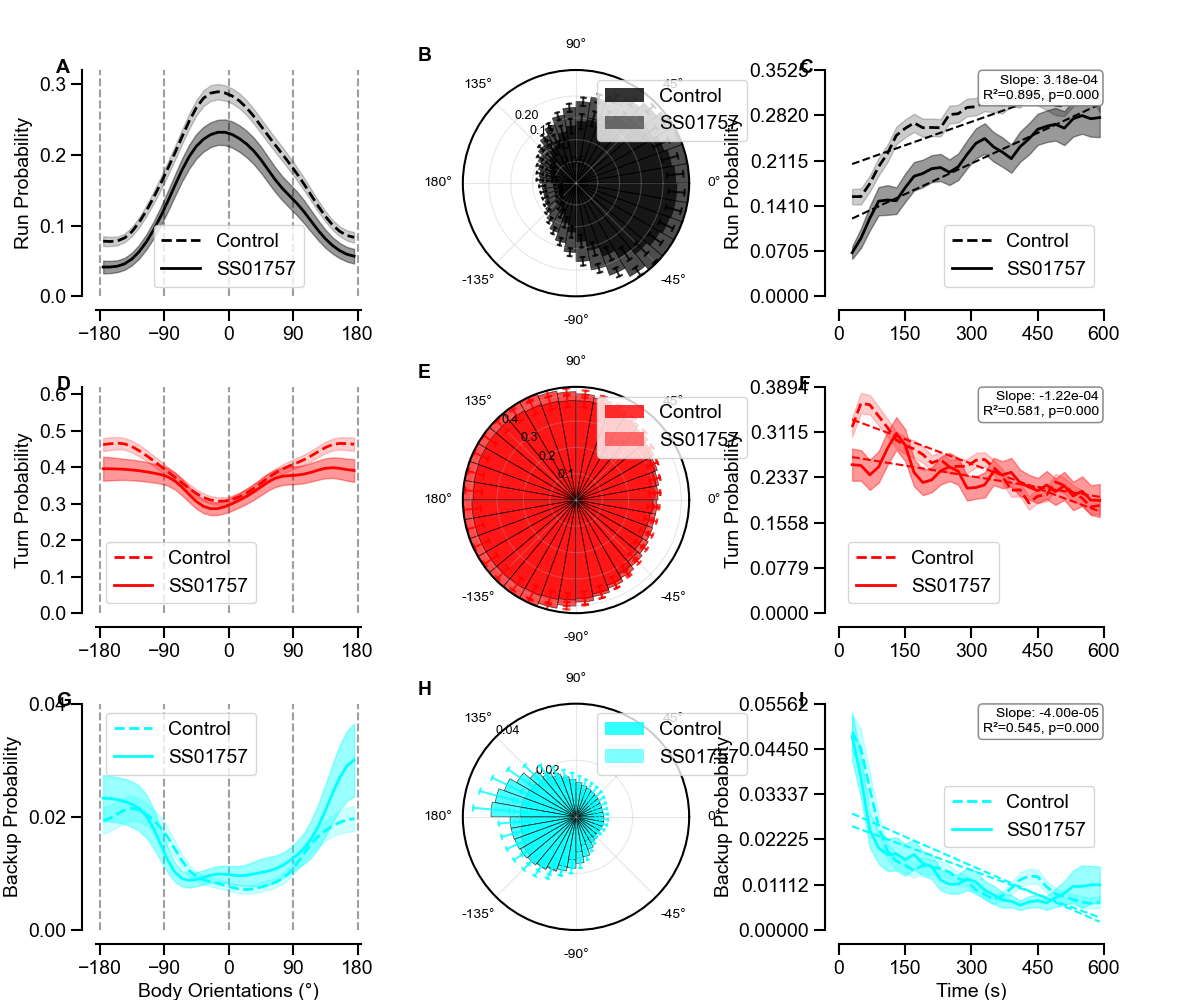

In [41]:
# Create genotype comparison figure for behavioral probabilities
def create_behavioral_probability_comparison(genotype_data, output_dir):
    """Create a 3x3 comparison figure for run, turn, and backup probabilities."""
    
    fig = plt.figure(figsize=(12, 10))
    gs = GridSpec(3, 3, figure=fig, 
                  left=0.08, right=0.92,
                  top=0.93, bottom=0.07,
                  wspace=0.4, hspace=0.4,
                  width_ratios=[0.6, 0.6, 0.6])

    # ========================
    # TOP ROW: Run Probability
    # ========================
    
    # Panel A: Run probability histogram
    ax1 = fig.add_subplot(gs[0, 0])
    plot_genotype_comparison(genotype_data, 'run_prob_results', 'histogram', 
                           ax=ax1, ylabel='Run Probability', show_xlabel=False,
                           plot_type='run')
    ax1.text(-0.15, 1.05, 'A', transform=ax1.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')
    
    # Panel B: Run probability polar
    ax2 = fig.add_subplot(gs[0, 1], projection='polar')
    plot_genotype_comparison(genotype_data, 'run_prob_results', 'polar', ax=ax2)
    ax2_pos = ax2.get_position()
    ax2.set_position([ax2_pos.x0 - 0.02, ax2_pos.y0, ax2_pos.width, ax2_pos.height])
    ax2.text(-0.2, 1.1, 'B', transform=ax2.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')
    
    # Panel C: Run probability time series
    ax3 = fig.add_subplot(gs[0, 2])
    plot_genotype_comparison(genotype_data, 'run_prob_time_results', 'time_series', 
                           ax=ax3, show_xlabel=False, plot_type='run')
    ax3.text(-0.15, 1.05, 'C', transform=ax3.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')

    # ========================
    # MIDDLE ROW: Turn Probability
    # ========================
    
    # Panel D: Turn probability histogram
    ax4 = fig.add_subplot(gs[1, 0])
    plot_genotype_comparison(genotype_data, 'turn_prob_results', 'histogram', 
                           ax=ax4, ylabel='Turn Probability', show_xlabel=False,
                           plot_type='turn')
    ax4.text(-0.15, 1.05, 'D', transform=ax4.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')
    
    # Panel E: Turn probability polar
    ax5 = fig.add_subplot(gs[1, 1], projection='polar')
    plot_genotype_comparison(genotype_data, 'turn_prob_results', 'polar', ax=ax5)
    ax5_pos = ax5.get_position()
    ax5.set_position([ax5_pos.x0 - 0.02, ax5_pos.y0, ax5_pos.width, ax5_pos.height])
    ax5.text(-0.2, 1.1, 'E', transform=ax5.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')
    
    # Panel F: Turn probability time series
    ax6 = fig.add_subplot(gs[1, 2])
    plot_genotype_comparison(genotype_data, 'turn_prob_time_results', 'time_series', 
                           ax=ax6, show_xlabel=False, plot_type='turn')
    ax6.text(-0.15, 1.05, 'F', transform=ax6.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')

    # ========================
    # BOTTOM ROW: Backup Probability
    # ========================
    
    # Panel G: Backup probability histogram
    ax7 = fig.add_subplot(gs[2, 0])
    plot_genotype_comparison(genotype_data, 'backup_prob_results', 'histogram', 
                           ax=ax7, ylabel='Backup Probability', show_xlabel=True,
                           plot_type='backup', color='cyan')
    ax7.text(-0.15, 1.05, 'G', transform=ax7.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')
    
    # Panel H: Backup probability polar
    ax8 = fig.add_subplot(gs[2, 1], projection='polar')
    plot_genotype_comparison(genotype_data, 'backup_prob_results', 'polar', ax=ax8)
    ax8_pos = ax8.get_position()
    ax8.set_position([ax8_pos.x0 - 0.02, ax8_pos.y0, ax8_pos.width, ax8_pos.height])
    ax8.text(-0.2, 1.1, 'H', transform=ax8.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')
    
    # Panel I: Backup probability time series
    ax9 = fig.add_subplot(gs[2, 2])
    plot_genotype_comparison(genotype_data, 'backup_prob_time_results', 'time_series', 
                           ax=ax9, show_xlabel=True, plot_type='backup')
    ax9.text(-0.15, 1.05, 'I', transform=ax9.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')
    
    # Create filename with genotype names
    genotype_labels = [data['metadata']['label'] for data in genotype_data.values()]
    genotype_string = '_vs_'.join(genotype_labels)
    filename = f'behavioral_probability_comparison_{genotype_string}.pdf'
    
    # Save figure
    fig.savefig(os.path.join(output_dir, filename), 
                bbox_inches='tight', dpi=300, transparent=True, facecolor='none')
    print(f"Behavioral probability comparison figure saved to: {os.path.join(output_dir, filename)}")
    

# Create the behavioral probability comparison figure
fig_behavioral = create_behavioral_probability_comparison(genotype_data, output_dir)
plt.show()

In [43]:
# # Create figure with asymmetric spacing - polar plots closer to left
# fig = plt.figure(figsize=(10, 8))
# gs = GridSpec(3, 3, figure=fig, 
#               left=0.08, right=0.90,
#               top=0.93, bottom=0.07,
#               wspace=0.4,               # Reduced overall spacing
#               hspace=0.4,
#               width_ratios=[0.6, 0.6, 0.6])  # Left wide, middle narrow, right wide

# # Row 1: Run analysis
# ax1 = fig.add_subplot(gs[0, 0])
# ax2 = fig.add_subplot(gs[0, 1], projection='polar')
# ax7 = fig.add_subplot(gs[0, 2])

# plot_data.plot_orientation_histogram(combined_run_prob, plot_type='run', ax=ax1, ylabel='Run Probability', show_xlabel=False)
# ax1.text(-0.15, 1.05, 'A', transform=ax1.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')

# plot_data.plot_orientation_histogram_polar(combined_run_prob, plot_type='run', ax=ax2, bar_style=True, tick_fontsize=10)
# ax2_pos = ax2.get_position()
# ax2.set_position([ax2_pos.x0 - 0.04, ax2_pos.y0, ax2_pos.width, ax2_pos.height])
# ax2.text(-0.2, 1.1, 'B', transform=ax2.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')

# plot_data.plot_metric_over_time(combined_run_prob_time, plot_type='run', ax=ax7, show_xlabel=False)
# ax7.text(-0.15, 1.05, 'C', transform=ax7.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')

# # Row 2: Turn analysis
# ax3 = fig.add_subplot(gs[1, 0])
# ax4 = fig.add_subplot(gs[1, 1], projection='polar')
# ax8 = fig.add_subplot(gs[1, 2])

# plot_data.plot_orientation_histogram(combined_turn_prob, plot_type='turn', ax=ax3, ylabel='Turn Probability', show_xlabel=False)
# ax3.text(-0.15, 1.05, 'D', transform=ax3.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')

# plot_data.plot_orientation_histogram_polar(combined_turn_prob, plot_type='turn', ax=ax4, bar_style=True, tick_fontsize=10)
# ax4_pos = ax4.get_position()
# ax4.set_position([ax4_pos.x0 - 0.04, ax4_pos.y0, ax4_pos.width, ax4_pos.height])
# ax4.text(-0.2, 1.1, 'E', transform=ax4.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')

# plot_data.plot_metric_over_time(combined_turn_prob_time, plot_type='turn', ax=ax8, show_xlabel=False)
# ax8.text(-0.15, 1.05, 'F', transform=ax8.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')

# # Row 3: Backup analysis
# ax5 = fig.add_subplot(gs[2, 0])
# ax6 = fig.add_subplot(gs[2, 1], projection='polar')
# ax9 = fig.add_subplot(gs[2, 2])

# plot_data.plot_orientation_histogram(combined_backup_prob, plot_type='backup', ax=ax5, ylabel='Backup Probability', color='cyan', show_xlabel=True)
# ax5.text(-0.15, 1.05, 'G', transform=ax5.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')

# plot_data.plot_orientation_histogram_polar(combined_backup_prob, plot_type='backup', ax=ax6, bar_style=True, tick_fontsize=10)
# ax6_pos = ax6.get_position()
# ax6.set_position([ax6_pos.x0 - 0.04, ax6_pos.y0, ax6_pos.width, ax6_pos.height])
# ax6.text(-0.2, 1.1, 'H', transform=ax6.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')

# plot_data.plot_metric_over_time(combined_backup_prob_time, plot_type='backup', ax=ax9, show_xlabel=True)
# ax9.text(-0.15, 1.05, 'I', transform=ax9.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')

# # fig.savefig(os.path.join(output_dir, 'behavioral_analysis_summary.pdf'), 
# #             bbox_inches='tight', 
# #             dpi=300,
# #             transparent=True,      # Transparent background
# #             facecolor='none')      # No face color

# # print(f"Saved to: {output_dir}")

In [45]:
# # Create combined figure with asymmetric spacing - polar plots closer to left
# fig_combined = plt.figure(figsize=(10, 6))
# gs_combined = GridSpec(2, 3, figure=fig_combined, 
#                       left=0.08, right=0.90,
#                       top=0.93, bottom=0.10,
#                       wspace=0.4,               # Reduced overall spacing
#                       hspace=0.4,
#                       width_ratios=[0.6, 0.6, 0.6])  # Left wide, middle narrow, right wide

# # Row 1: Run Velocity Analysis
# ax_vel1 = fig_combined.add_subplot(gs_combined[0, 0])
# ax_vel2 = fig_combined.add_subplot(gs_combined[0, 1], projection='polar')
# ax_vel3 = fig_combined.add_subplot(gs_combined[0, 2])

# # Linear plot
# plot_data.plot_orientation_histogram(combined_velocity, ax=ax_vel1, show_xlabel=False, ylabel='Run Velocity (body lengths/s)')
# ax_vel1.text(-0.15, 1.05, 'A', transform=ax_vel1.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')

# # Polar plot
# plot_data.plot_orientation_histogram_polar(combined_velocity, ax=ax_vel2, bar_style=True, tick_fontsize=10)
# ax_vel2_pos = ax_vel2.get_position()
# ax_vel2.set_position([ax_vel2_pos.x0 - 0.04, ax_vel2_pos.y0, ax_vel2_pos.width, ax_vel2_pos.height])
# ax_vel2.text(-0.2, 1.1, 'B', transform=ax_vel2.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')

# # Time series plot
# plot_data.plot_metric_over_time(
#     combined_velocity_time, color='black', ylabel='Run Velocity (body lengths/s)',
#     show_individuals=False, show_error=True, ax=ax_vel3, show_xlabel=False
# )
# ax_vel3.text(-0.15, 1.05, 'C', transform=ax_vel3.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')

# # Row 2: Turn Amplitude Analysis
# ax_amp1 = fig_combined.add_subplot(gs_combined[1, 0])
# ax_amp2 = fig_combined.add_subplot(gs_combined[1, 1], projection='polar')
# ax_amp3 = fig_combined.add_subplot(gs_combined[1, 2])

# # Set minimum amplitude
# min_amp = 45

# # Check if we have ANY valid (non-NaN) data
# if combined_turn_amp and 'mean_hist' in combined_turn_amp:
#     mean_hist = np.array(combined_turn_amp['mean_hist'])
#     has_data = np.any(~np.isnan(mean_hist))
# else:
#     has_data = False

# # Linear plot
# plot_data.plot_orientation_histogram(combined_turn_amp, ax=ax_amp1, ylabel='Turn Amplitude (°)', 
#                                      show_xlabel=True, ylim=[60,90], min_amplitude=min_amp, plot_type='turn_amplitude')
# ax_amp1.text(-0.15, 1.05, 'D', transform=ax_amp1.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')

# # Polar plot - only if there's valid data
# plot_data.plot_orientation_histogram_polar(combined_turn_amp, ax=ax_amp2, bar_style=True, 
#                                     tick_fontsize=10, min_amplitude=min_amp, plot_type='turn_amplitude')
# ax_amp2_pos = ax_amp2.get_position()
# ax_amp2.set_position([ax_amp2_pos.x0 - 0.04, ax_amp2_pos.y0, ax_amp2_pos.width, ax_amp2_pos.height])
# ax_amp2.text(-0.2, 1.1, 'E', transform=ax_amp2.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')

# # Time series plot
# plot_data.plot_metric_over_time(
#     combined_turn_amp_time, plot_type='turn_amplitude', 
#     show_individuals=False, show_error=True, ax=ax_amp3, show_xlabel=True,
#     min_amplitude=min_amp
# )
# ax_amp3.text(-0.15, 1.05, 'F', transform=ax_amp3.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')

# # Save the combined figure
# # fig_combined.savefig(os.path.join(output_dir, 'velocity_amplitude_analysis.pdf'), 
# #                     bbox_inches='tight', 
# #                     dpi=300,
# #                     transparent=True,
# #                     facecolor='none')
# # print(f"Combined velocity & amplitude figure saved to: {os.path.join(output_dir, 'velocity_amplitude_analysis.pdf')}")

# plt.show()

In [46]:
# # 3. Plot time series
# fig_time = plot_data.plot_navigational_index_over_time(
#     combined_ni_time,
#     save_path=os.path.join(output_dir, 'ni_over_time.pdf')
# )

# # 4. Plot box plots
# fig_box = plot_data.plot_navigational_index_boxplot(
#     combined_ni_single,
#     save_path=os.path.join(output_dir, 'ni_boxplot.pdf')
# )

# # 5. Plot box plots by date
# fig_box_by_date = plot_data.plot_ni_boxplot_by_date(
#     combined_ni_single,
#     save_path=os.path.join(output_dir, 'ni_boxplot_by_date.pdf')
# )

# # Print summary of data by date
# if combined_ni_single and 'NI_x_by_date' in combined_ni_single:
#     print("\n📅 NI data summary by date:")
#     ni_x_by_date = combined_ni_single['NI_x_by_date']
#     ni_y_by_date = combined_ni_single['NI_y_by_date']
    
#     for date in sorted(ni_x_by_date.keys()):
#         n_x = len(ni_x_by_date.get(date, []))
#         n_y = len(ni_y_by_date.get(date, []))
#         mean_x = np.nanmean(ni_x_by_date.get(date, [])) if n_x > 0 else np.nan
#         mean_y = np.nanmean(ni_y_by_date.get(date, [])) if n_y > 0 else np.nan
#         print(f"  {date}: {n_x} larvae, NI_x mean={mean_x:.3f}, NI_y mean={mean_y:.3f}")

In [47]:
# # Create combined figure for head cast analysis - matching the style of other analysis plots
# fig_head_casts = plt.figure(figsize=(10, 4))  # Single row, so height is 4
# gs_head_casts = GridSpec(1, 3, figure=fig_head_casts, 
#                         left=0.08, right=0.90,
#                         top=0.93, bottom=0.15,  # More bottom space for single row
#                         wspace=0.4,               
#                         width_ratios=[0.6, 0.6, 0.6])

# # Row 1: Head Cast Analysis
# ax_hc1 = fig_head_casts.add_subplot(gs_head_casts[0, 0])
# ax_hc2 = fig_head_casts.add_subplot(gs_head_casts[0, 1], projection='polar')
# ax_hc3 = fig_head_casts.add_subplot(gs_head_casts[0, 2])

# # Linear plot - Head cast frequency by orientation
# plot_data.plot_orientation_histogram(combined_head_cast_orientation,
#                                    ylim=[0, 5], 
#                                    plot_type='head_cast',
#                                    ax=ax_hc1, 
#                                    show_xlabel=True, 
#                                    ylabel='Head Cast Number')
# ax_hc1.text(-0.15, 1.05, 'A', transform=ax_hc1.transAxes, 
#             fontsize=14, fontweight='bold', va='top', ha='left')

# # Polar plot - Head cast frequency by orientation
# plot_data.plot_orientation_histogram_polar(combined_head_cast_orientation, 
#                                          ax=ax_hc2, 
#                                          plot_type='head_cast',
#                                          bar_style=True, 
#                                          tick_fontsize=10)
# ax_hc2_pos = ax_hc2.get_position()
# ax_hc2.set_position([ax_hc2_pos.x0 - 0.04, ax_hc2_pos.y0, ax_hc2_pos.width, ax_hc2_pos.height])
# ax_hc2.text(-0.2, 1.1, 'B', transform=ax_hc2.transAxes, 
#             fontsize=14, fontweight='bold', va='top', ha='left')

# # Time series plot - Head cast frequency over time
# plot_data.plot_metric_over_time(
#     combined_head_cast_time, plot_type='head_cast', ylabel='Head Cast Rate (per second)',
#     show_individuals=False, show_error=True, ax=ax_hc3, show_xlabel=True
# )
# ax_hc3.text(-0.15, 1.05, 'C', transform=ax_hc3.transAxes, 
#             fontsize=14, fontweight='bold', va='top', ha='left')

# # Save the head cast analysis figure
# # fig_head_casts.savefig(os.path.join(output_dir, 'head_cast_analysis.pdf'), 
# #                       bbox_inches='tight', 
# #                       dpi=300,
# #                       transparent=True,
# #                       facecolor='none')
# print(f"Head cast analysis figure saved to: {os.path.join(output_dir, 'head_cast_analysis.pdf')}")

# plt.show()

In [48]:
# # Create 1x2 figure layout for turn bias and first head cast bias only
# fig_bias = plt.figure(figsize=(6,6))  # Reduced width for 2 plots
# gs_bias = GridSpec(1, 2, figure=fig_bias, 
#                    left=0.08, right=0.92,  # Adjusted margins
#                    top=0.85, bottom=0.15,
#                    wspace=0.3)  # Spacing for 2 plots

# # Panel A: Turn bias (first panel)
# ax_bias1 = fig_bias.add_subplot(gs_bias[0, 0])
# plot_data.plot_head_cast_bias_perpendicular(
#     combined_bias_turn,
#     ax=ax_bias1,
#     title='Turn Bias'
# )
# ax_bias1.text(-0.15, 1.05, 'A', transform=ax_bias1.transAxes, 
#               fontsize=14, fontweight='bold', va='top', ha='left')

# # Panel B: First head cast bias (second panel)
# ax_bias2 = fig_bias.add_subplot(gs_bias[0, 1])
# plot_data.plot_head_cast_bias_perpendicular(
#     combined_bias_first,
#     ax=ax_bias2,
#     title='First Head Cast Bias'
# )
# ax_bias2.text(-0.15, 1.05, 'B', transform=ax_bias2.transAxes, 
#               fontsize=14, fontweight='bold', va='top', ha='left')
# ax_bias2.set_ylabel('')  # Remove y-label for second plot

# # Save the combined figure
# # fig_bias.savefig(os.path.join(output_dir, 'head_cast_bias_turn_and_first.pdf'), 
# #                 bbox_inches='tight', 
# #                 dpi=300,
# #                 transparent=True,
# #                 facecolor='none')
# # print(f"Turn bias and first head cast bias figure saved to: {os.path.join(output_dir, 'head_cast_bias_turn_and_first.pdf')}")

# plt.show()


=== MEDIANS AND QUARTILES ===
Towards Wind - Median: 0.000, Q1: 0.000, Q3: 0.500
Away from Wind - Median: 1.000, Q1: 0.500, Q3: 1.000

=== MEDIANS AND QUARTILES ===
Towards Wind - Median: 0.000, Q1: 0.000, Q3: 0.333
Away from Wind - Median: 1.000, Q1: 0.667, Q3: 1.000

=== MEDIANS AND QUARTILES ===
Towards Wind - Median: 0.400, Q1: 0.167, Q3: 0.571
Away from Wind - Median: 0.600, Q1: 0.429, Q3: 0.833

=== MEDIANS AND QUARTILES ===
Towards Wind - Median: 0.354, Q1: 0.025, Q3: 0.567
Away from Wind - Median: 0.646, Q1: 0.433, Q3: 0.975
Head cast comprehensive comparison figure saved to: /Users/sharbat/Projects/anemotaxis/data/genotype_comparison/head_cast_comprehensive_comparison_Control_vs_SS01757.pdf


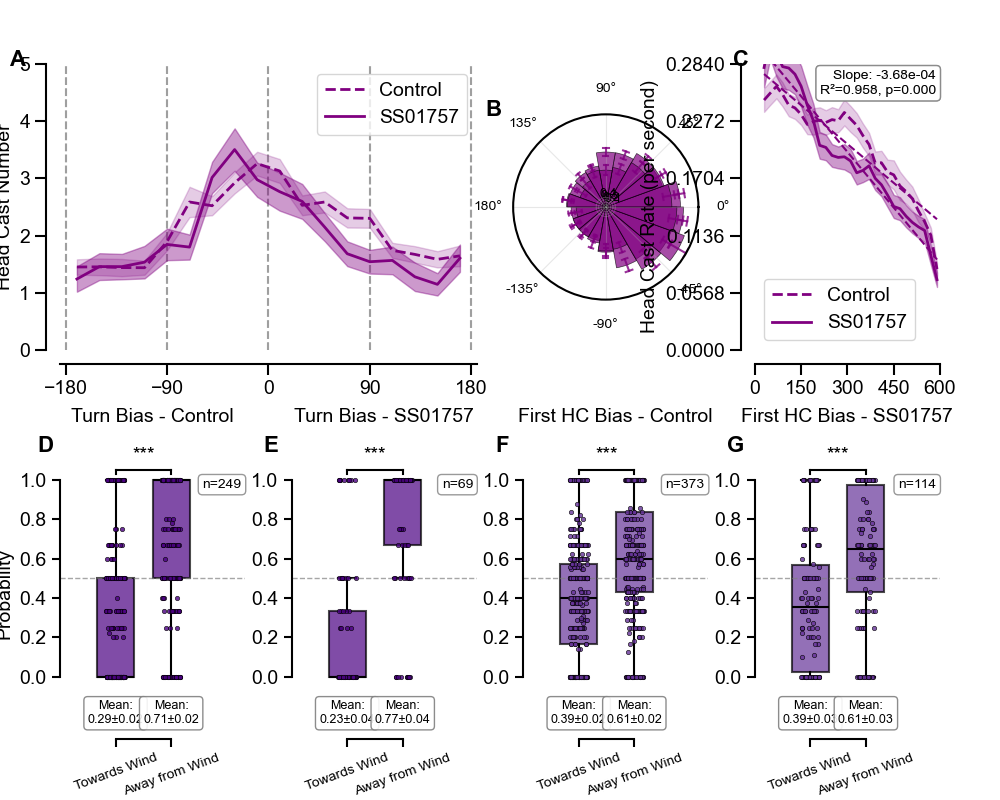

In [49]:
def create_head_cast_comprehensive_comparison(genotype_data, output_dir):
    """Create a comprehensive head cast comparison figure with analysis and bias plots."""
    
    # Adjusted figure size for better proportions
    fig = plt.figure(figsize=(10,8))  # Wider for better panel distribution
    gs = GridSpec(2, 4, figure=fig, 
                  left=0.06, right=0.94,
                  top=0.92, bottom=0.08,
                  wspace=0.25, hspace=0.35,
                  width_ratios=[1.0, 1.0, 1.0, 1.0],  # Equal width for all 4 bottom panels
                  height_ratios=[1, 1])  # Equal height for both rows

    # ========================
    # TOP ROW: Head Cast Orientation Analysis Comparison (3 panels spanning 4 columns)
    # ========================
    
    # Panel A: Head cast orientation histogram comparison (spans columns 0-1)
    ax1 = fig.add_subplot(gs[0, :2])  # Span first 2 columns
    plot_genotype_comparison(genotype_data, 'head_cast_orientation_results', 'histogram', 
                           ax=ax1, ylabel='Head Cast Number', show_xlabel=False,
                           plot_type='head_cast', ylim=[0, 5])
    ax1.text(-0.12, 1.05, 'A', transform=ax1.transAxes, fontsize=16, fontweight='bold', va='top', ha='left')
    
    # Panel B: Head cast orientation polar comparison (column 2)
    ax2 = fig.add_subplot(gs[0, 2], projection='polar')
    plot_genotype_comparison(genotype_data, 'head_cast_orientation_results', 'polar', ax=ax2, 
                           plot_type='head_cast')
    # Remove legend from polar plot
    if ax2.get_legend():
        ax2.get_legend().remove()
    ax2_pos = ax2.get_position()
    ax2.set_position([ax2_pos.x0 - 0.01, ax2_pos.y0, ax2_pos.width, ax2_pos.height])
    ax2.text(-0.15, 1.08, 'B', transform=ax2.transAxes, fontsize=16, fontweight='bold', va='top', ha='left')
    
    # Panel C: Head cast rate time series comparison (column 3)
    ax3 = fig.add_subplot(gs[0, 3])
    plot_genotype_comparison(genotype_data, 'head_cast_time_results', 'time_series', 
                           ax=ax3, show_xlabel=False, plot_type='head_cast',
                           ylabel='Head Cast Rate (per second)')
    ax3.text(-0.12, 1.05, 'C', transform=ax3.transAxes, fontsize=16, fontweight='bold', va='top', ha='left')

    # ========================
    # BOTTOM ROW: Bias Analysis - Turn Bias (D,E) and First HC Bias (F,G)
    # ========================
    
    # Get genotype data
    genotype_keys = list(genotype_data.keys())
    genotype_labels = [genotype_data[key]['metadata']['label'] for key in genotype_keys]
    
    # Panel D: Control Turn Bias (column 0)
    ax4 = fig.add_subplot(gs[1, 0])
    control_data = genotype_data[genotype_keys[0]]
    control_label = control_data['metadata']['label']
    if 'bias_results_turn' in control_data and control_data['bias_results_turn']:
        plot_data.plot_head_cast_bias_perpendicular(
            control_data['bias_results_turn'],
            ax=ax4,
            title=f'Turn Bias - {control_label}'
        )
    ax4.text(-0.12, 1.05, 'D', transform=ax4.transAxes, fontsize=16, fontweight='bold', va='top', ha='left')
    
    # Panel E: Experimental Genotype Turn Bias (column 1)
    ax5 = fig.add_subplot(gs[1, 1])
    if len(genotype_keys) > 1:
        experimental_data = genotype_data[genotype_keys[1]]
        experimental_label = experimental_data['metadata']['label']
        if 'bias_results_turn' in experimental_data and experimental_data['bias_results_turn']:
            plot_data.plot_head_cast_bias_perpendicular(
                experimental_data['bias_results_turn'],
                ax=ax5,
                title=f'Turn Bias - {experimental_label}'
            )
    ax5.set_ylabel('')  # Remove y-label for consistency
    ax5.text(-0.15, 1.05, 'E', transform=ax5.transAxes, fontsize=16, fontweight='bold', va='top', ha='left')
    
    # Panel F: Control First HC Bias (column 2)
    ax6 = fig.add_subplot(gs[1, 2])
    if 'bias_results_first' in control_data and control_data['bias_results_first']:
        plot_data.plot_head_cast_bias_perpendicular(
            control_data['bias_results_first'],
            ax=ax6,
            title=f'First HC Bias - {control_label}'
        )
    ax6.set_ylabel('')  # Remove y-label for consistency
    ax6.text(-0.15, 1.05, 'F', transform=ax6.transAxes, fontsize=16, fontweight='bold', va='top', ha='left')
    
    # Panel G: Experimental Genotype First HC Bias (column 3)
    ax7 = fig.add_subplot(gs[1, 3])
    if len(genotype_keys) > 1:
        if 'bias_results_first' in experimental_data and experimental_data['bias_results_first']:
            plot_data.plot_head_cast_bias_perpendicular(
                experimental_data['bias_results_first'],
                ax=ax7,
                title=f'First HC Bias - {experimental_label}'
            )
    ax7.set_ylabel('')  # Remove y-label for consistency
    ax7.text(-0.15, 1.05, 'G', transform=ax7.transAxes, fontsize=16, fontweight='bold', va='top', ha='left')
    
    # Create filename with genotype names
    genotype_string = '_vs_'.join(genotype_labels)
    filename = f'head_cast_comprehensive_comparison_{genotype_string}.pdf'
    
    # Save figure
    fig.savefig(os.path.join(output_dir, filename), 
                bbox_inches='tight', dpi=300, transparent=True, facecolor='none')
    print(f"Head cast comprehensive comparison figure saved to: {os.path.join(output_dir, filename)}")
    
    return fig

# Create the comprehensive head cast comparison figure
fig_head_cast_comprehensive = create_head_cast_comprehensive_comparison(genotype_data, output_dir)
plt.show()

In [ ]:
import json
import numpy as np

def save_figure_metadata(output_dir, figure_name, result_files, additional_info=None):
    """
    Save metadata about the files and parameters used to generate a figure.
    
    Args:
        output_dir: Directory where the figure and metadata are saved
        figure_name: Name of the figure (without extension)
        result_files: List of HDF5 files used to generate the figure
        additional_info: Optional dictionary with additional metadata
    """
    def convert_numpy_types(obj):
        """Convert numpy types to Python native types for JSON serialization."""
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        elif isinstance(obj, dict):
            return {key: convert_numpy_types(value) for key, value in obj.items()}
        elif isinstance(obj, list):
            return [convert_numpy_types(item) for item in obj]
        elif isinstance(obj, tuple):
            return tuple(convert_numpy_types(item) for item in obj)
        else:
            return obj
    
    metadata = {
        'figure_name': figure_name,
        'generated_date': datetime.now().isoformat(),
        'source_files': [],
        'total_larvae': 0,
        'experiment_dates': [],
        'analysis_info': additional_info or {}
    }
    
    # Extract information from each source file
    for filepath in result_files:
        try:
            results = load_analysis_results(filepath)
            source_metadata = results.get('metadata', {})
            
            # Extract experiment date from path
            path_parts = filepath.split('/')
            experiment_date = 'unknown'
            for part in path_parts:
                if len(part) == 15 and part.startswith('202'):  # Format: 20240226_145653
                    experiment_date = part
                    break
            
            file_info = {
                'filepath': filepath,
                'original_trx_file': source_metadata.get('source_file', 'unknown'),
                'analysis_date': source_metadata.get('created_date', 'unknown'),
                'n_larvae': int(source_metadata.get('n_larvae_total', 0)),  # Convert to int
                'experiment_date': experiment_date
            }
            
            metadata['source_files'].append(file_info)
            metadata['total_larvae'] += file_info['n_larvae']
            
            if experiment_date not in metadata['experiment_dates']:
                metadata['experiment_dates'].append(experiment_date)
                
        except Exception as e:
            print(f"⚠️  Could not extract metadata from {filepath}: {e}")
    
    # Sort experiment dates
    metadata['experiment_dates'].sort()
    
    # Add summary statistics
    metadata['summary'] = {
        'n_source_files': len(result_files),
        'n_experiments': len(metadata['experiment_dates']),
        'total_larvae': metadata['total_larvae'],
        'date_range': f"{metadata['experiment_dates'][0]} to {metadata['experiment_dates'][-1]}" if metadata['experiment_dates'] else "unknown"
    }
    
    # Convert all numpy types to Python types
    metadata = convert_numpy_types(metadata)
    
    # Save metadata as JSON
    metadata_filepath = os.path.join(output_dir, f'{figure_name}_metadata.json')
    with open(metadata_filepath, 'w') as f:
        json.dump(metadata, f, indent=2)
    
    print(f"📋 Metadata saved to: {metadata_filepath}")
    return metadata_filepath

# Save metadata for the main behavioral analysis figure
behavioral_metadata = save_figure_metadata(
    output_dir, 
    'behavioral_analysis_summary',
    result_files,
    additional_info={
        'analysis_types': ['run_probability', 'turn_probability', 'backup_probability'],
        'plot_types': ['linear_orientation', 'polar_orientation', 'time_series'],
        'parameters': {
            'run_prob_ylim': [0, 0.5],  # Convert tuple to list
            'turn_prob_ylim': [0, 0.4],
            'backup_prob_ylim': [0, 0.1]
        },
        'figure_layout': '3x3 grid',
        'genotype': 'FCF_attP2-40@UAS_TNT_2_0003',
        'condition': 'p_5gradient2_2s1x600s0s#n#n#n'
    }
)

# Save metadata for the velocity & amplitude analysis figure  
velocity_metadata = save_figure_metadata(
    output_dir,
    'velocity_amplitude_analysis', 
    result_files,
    additional_info={
        'analysis_types': ['run_velocity', 'turn_amplitude'],
        'plot_types': ['linear_orientation', 'polar_orientation', 'time_series'],
        'parameters': {
            'min_turn_amplitude': 60,
            'velocity_units': 'body_lengths_per_second',
            'amplitude_units': 'degrees'
        },
        'figure_layout': '2x3 grid',
        'genotype': 'FCF_attP2-40@UAS_TNT_2_0003',
        'condition': 'p_5gradient2_2s1x600s0s#n#n#n'
    }
)

NameError: name 'result_files' is not defined